<a href="https://colab.research.google.com/github/a-m-kacz/MLA/blob/main/lab5_albumentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import cv2

import albumentations as A
# from albumentations.pytorch import ToTensor

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .9
# the number of epochs is the number of times you go through the full dataset
model_args['weight_decay'] = 5.e-4
model_args['epochs'] = 60

Dowload a dataset using *torchvision* and create dataloader. 

In [33]:
transform = transforms.ToTensor()
train_subset = datasets.MNIST('../data', train=True, download=True, transform=transform)
loader_kwargs = {'batch_size': 1, 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = DataLoader(train_subset)

Load images from the dataset and save as separate images.

In [34]:
dataset_directory = os.path.join('./', "dataset")
os.makedirs(dataset_directory, exist_ok=True)
images_filepaths = []
images_labels = []
for i, (image, label) in enumerate(train_loader):
    filepath = os.path.join(dataset_directory, str(i)+".png")
    cv2.imwrite(filepath, image.numpy()[0,0]) 
    images_filepaths.append(filepath)
    images_labels.append(label.item())

Now define dataset with some *albumentations*.

In [36]:
class AlbumentationsDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        
        # Read an image with OpenCV
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label


albumentations_transform = A.Compose([
    A.VerticalFlip(),
    A.HorizontalFlip()
])

albumentations_dataset = AlbumentationsDataset(
    file_paths=images_filepaths,
    labels=images_labels,
    transform=albumentations_transform,
)

Plot sample images after augmentation

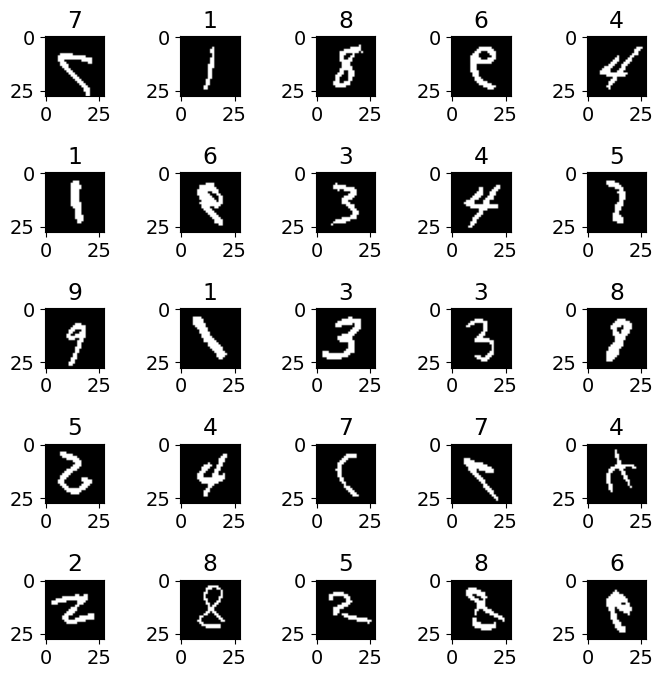

In [37]:
example_number = 123
fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(albumentations_dataset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(albumentations_dataset[example_number+i*5+j][1])

Note that the default transformation probability is 0.5

In [38]:
len(albumentations_dataset)

60000

nowy train subset na albumentations - tak jest ok?

In [42]:
train_subset, validation_subset = torch.utils.data.random_split(albumentations_dataset, [45000, 15000])

test_subset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_subset, range(5000))


train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

In [43]:
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}

In [44]:
def train(model, device, train_loader, optimizer, criterion, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate loss using c
        loss = criterion(output, target)
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        train_loss += loss.item()
    print('Train Epoch: {}'.format(epoch_number))
    train_loss /= len(train_loader)
    print('\tTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, criterion, message=None):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += criterion(output, target) 
            # get the index of class with the max probability 
            prediction = output.argmax(dim=1)  
            #_, predicted = torch.max(outputs.data, axis=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    if message is not None:
        print('\t{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            message, test_loss, correct, len(test_loader.dataset), 100.*accuracy))
    return test_loss.cpu(), accuracy

def run_training(model, criterion, optimizer, no_epochs):
    train_loss = []
    validation_loss = []
    validation_accuracy = []
    test_accuracy = []
    for epoch_number in range(1, no_epochs+1):
        train_loss.append(train(model, device, train_loader, 
                                optimizer, criterion, epoch_number))
        val_loss, val_acc = test(model, device, validation_loader, 
                                criterion, 'Validation set')
        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)
        # we also collect test accuracies for every epoch
        _, test_acc = test(model, device, test_loader, criterion)
        test_accuracy.append(test_acc)
    # and select test accuracy for the best epoch (with the highest validation accuracy)
    best_accuracy = test_accuracy[np.argmax(validation_accuracy)]
    return train_loss, validation_loss, best_accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=.5,
                      weight_decay=1.e-3)
no_epochs = model_args['epochs']

train_loss, val_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss, val_loss, 'VGG11 model')

RuntimeError: ignored